In [158]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib2
import urllib
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split  
from sklearn.metrics import classification_report, confusion_matrix  

WeatherData = pd.read_csv("./Weather Data.csv");
WeatherData = pd.DataFrame(data = WeatherData)
CrimeData = pd.read_csv("./Crime Data.csv");
CrimeData = pd.DataFrame(data = CrimeData)
sns.__version__

'0.9.0'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11521 entries, 0 to 11520
Data columns (total 8 columns):
Date                      365 non-null object
HOURLYVISIBILITY          365 non-null float64
HOURLYDRYBULBTEMPF        365 non-null float64
HOURLYRelativeHumidity    365 non-null float64
HOURLYWindSpeed           365 non-null float64
HOURLYStationPressure     365 non-null float64
DAILYSunrise              365 non-null float64
DAILYSunset               365 non-null float64
dtypes: float64(7), object(1)
memory usage: 720.1+ KB
None


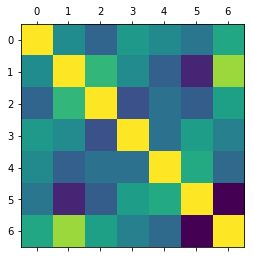

In [139]:
print WeatherData.info()

plt.matshow(WeatherData.corr())

In [140]:

names = list(CrimeData)
#time_to_float can only be ran once
i = 0;
def time_to_float(time_str):
    time_str = str(time_str)
    return float(time_str.replace(":",""))
CrimeData['occur_time'] = CrimeData['occur_time'].apply(time_to_float)
print CrimeData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 10 columns):
Date                26748 non-null object
occur_time          26748 non-null float64
poss_date           26748 non-null object
poss_time           26745 non-null object
MaxOfnum_victims    26684 non-null float64
Avg Day             26748 non-null object
UC2 Literal         26748 non-null object
neighborhood        25563 non-null object
x                   26748 non-null float64
y                   26748 non-null float64
dtypes: float64(4), object(6)
memory usage: 2.0+ MB
None


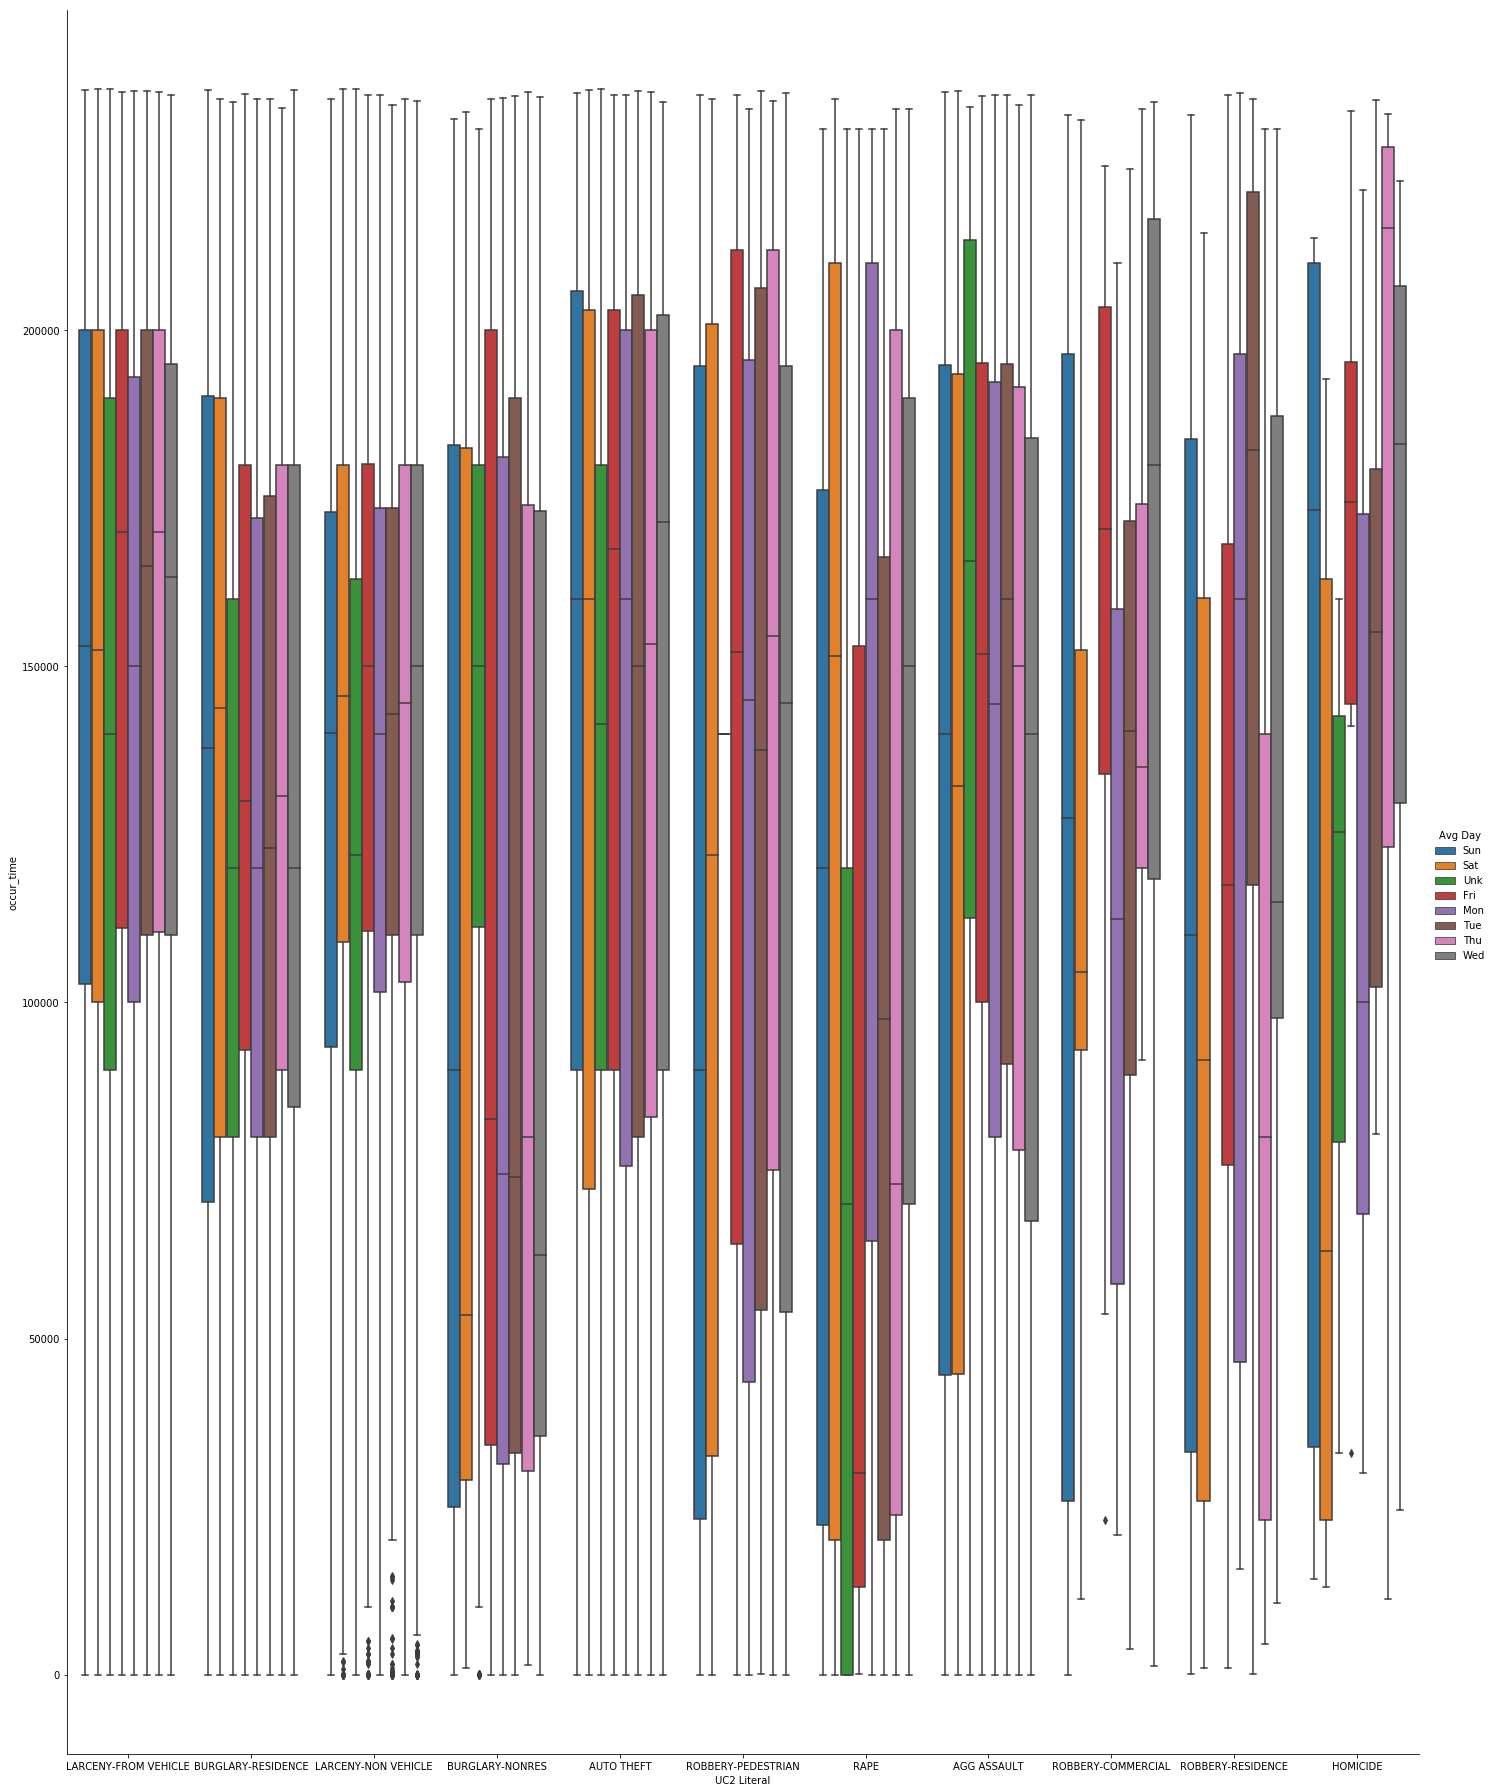

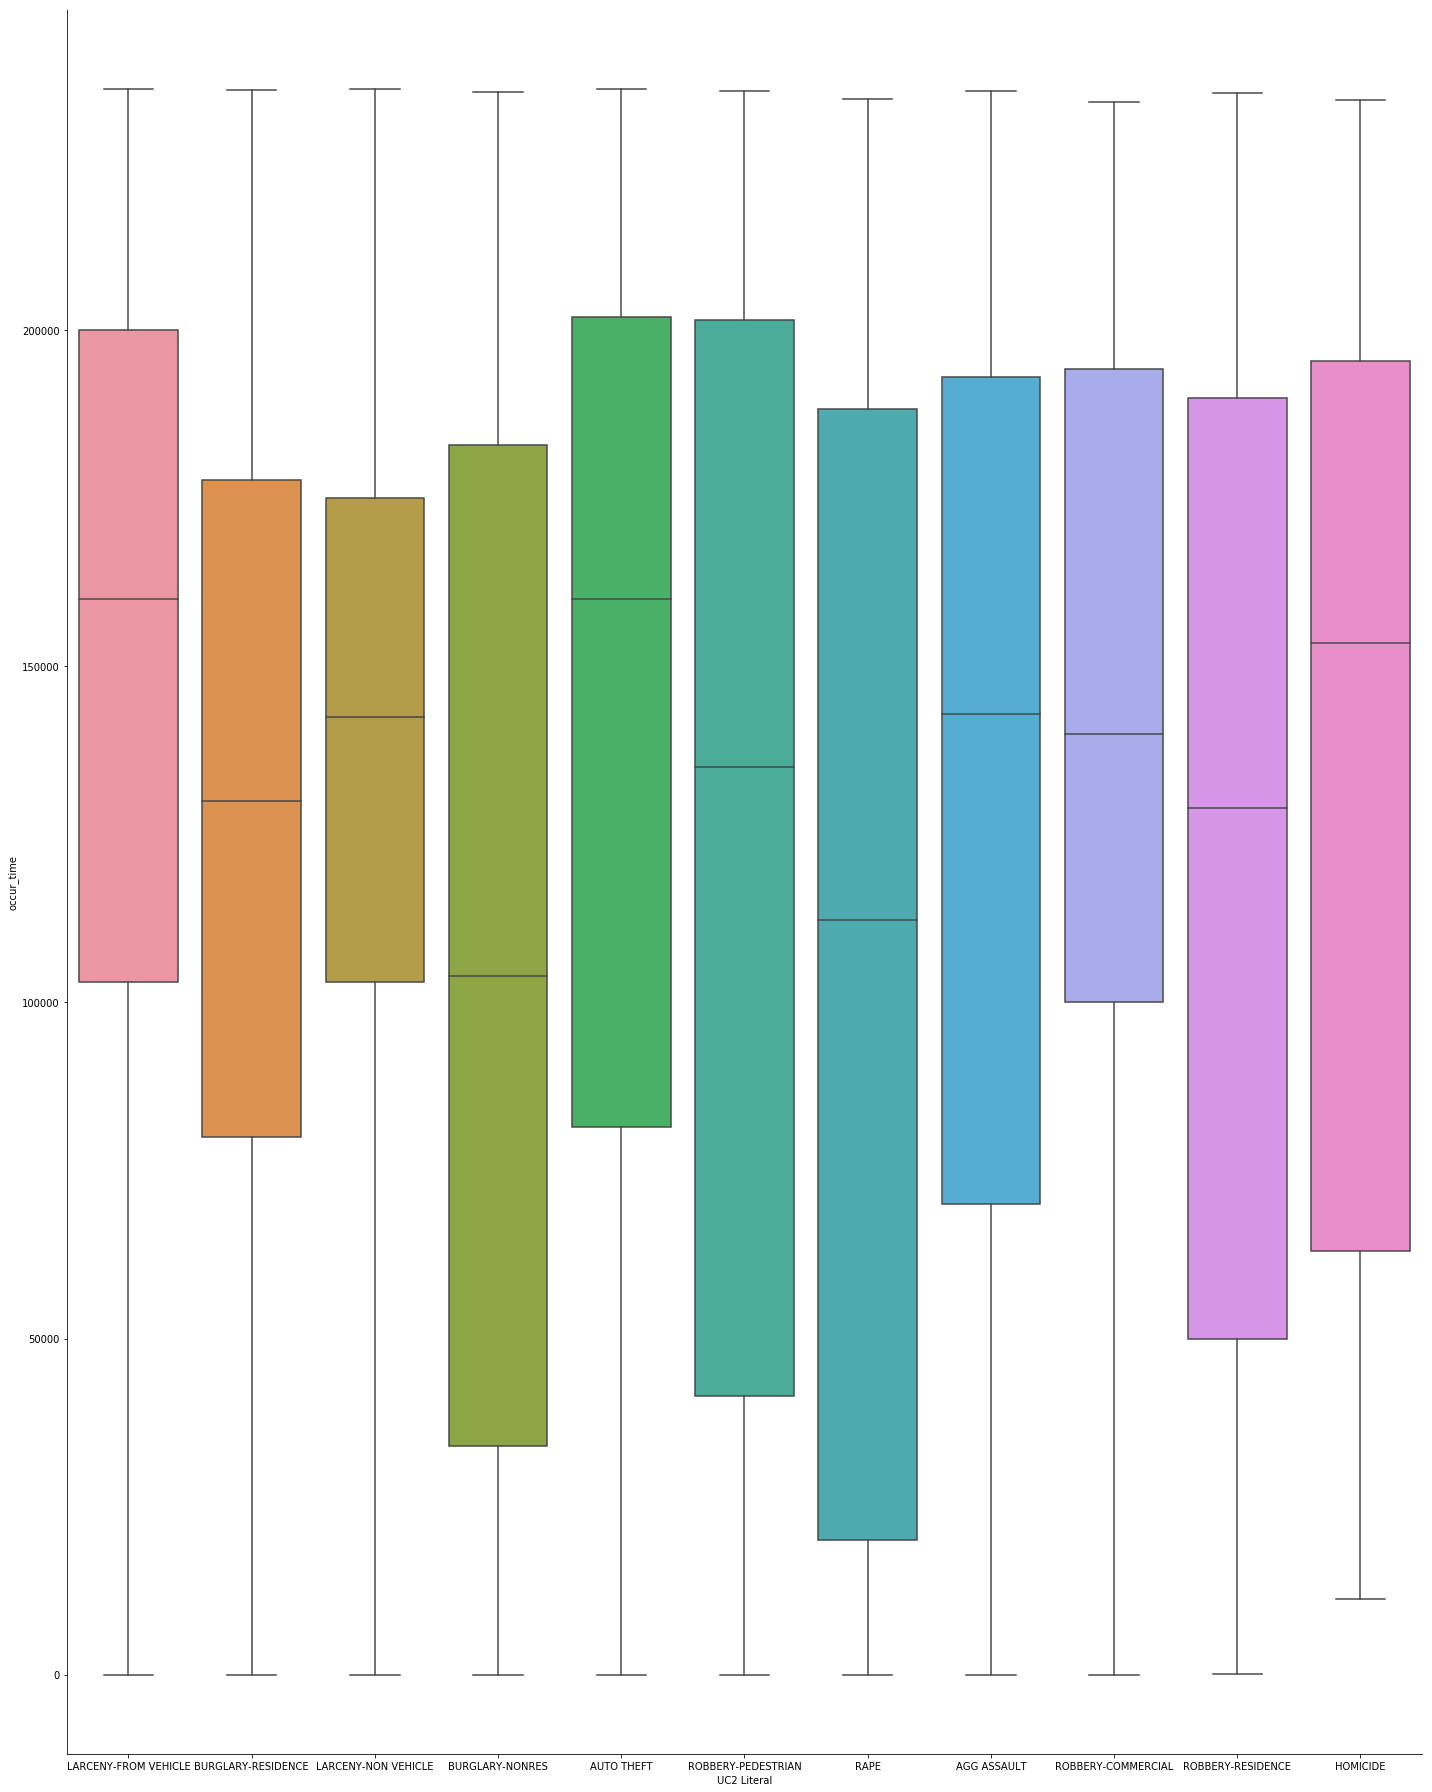

In [141]:
sns.catplot(x="UC2 Literal", y="occur_time", hue="Avg Day", kind = 'box', data=CrimeData, height = 25, aspect = .8);
sns.catplot(x="UC2 Literal", y="occur_time", kind = 'box', data=CrimeData, height = 25, aspect = .8);

In [142]:
CrimeWeatherData = [CrimeData, WeatherData]
CrimeWeatherData = CrimeData.merge(WeatherData,how='left', left_on='Date', right_on='Date')
CrimeWeatherData = CrimeWeatherData[pd.notnull(CrimeWeatherData['Date'])]
print CrimeWeatherData.info()
print CrimeWeatherData

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26748 entries, 0 to 26747
Data columns (total 17 columns):
Date                      26748 non-null object
occur_time                26748 non-null float64
poss_date                 26748 non-null object
poss_time                 26745 non-null object
MaxOfnum_victims          26684 non-null float64
Avg Day                   26748 non-null object
UC2 Literal               26748 non-null object
neighborhood              25563 non-null object
x                         26748 non-null float64
y                         26748 non-null float64
HOURLYVISIBILITY          26748 non-null float64
HOURLYDRYBULBTEMPF        26748 non-null float64
HOURLYRelativeHumidity    26748 non-null float64
HOURLYWindSpeed           26748 non-null float64
HOURLYStationPressure     26748 non-null float64
DAILYSunrise              26748 non-null float64
DAILYSunset               26748 non-null float64
dtypes: float64(11), object(6)
memory usage: 3.7+ MB
None
      

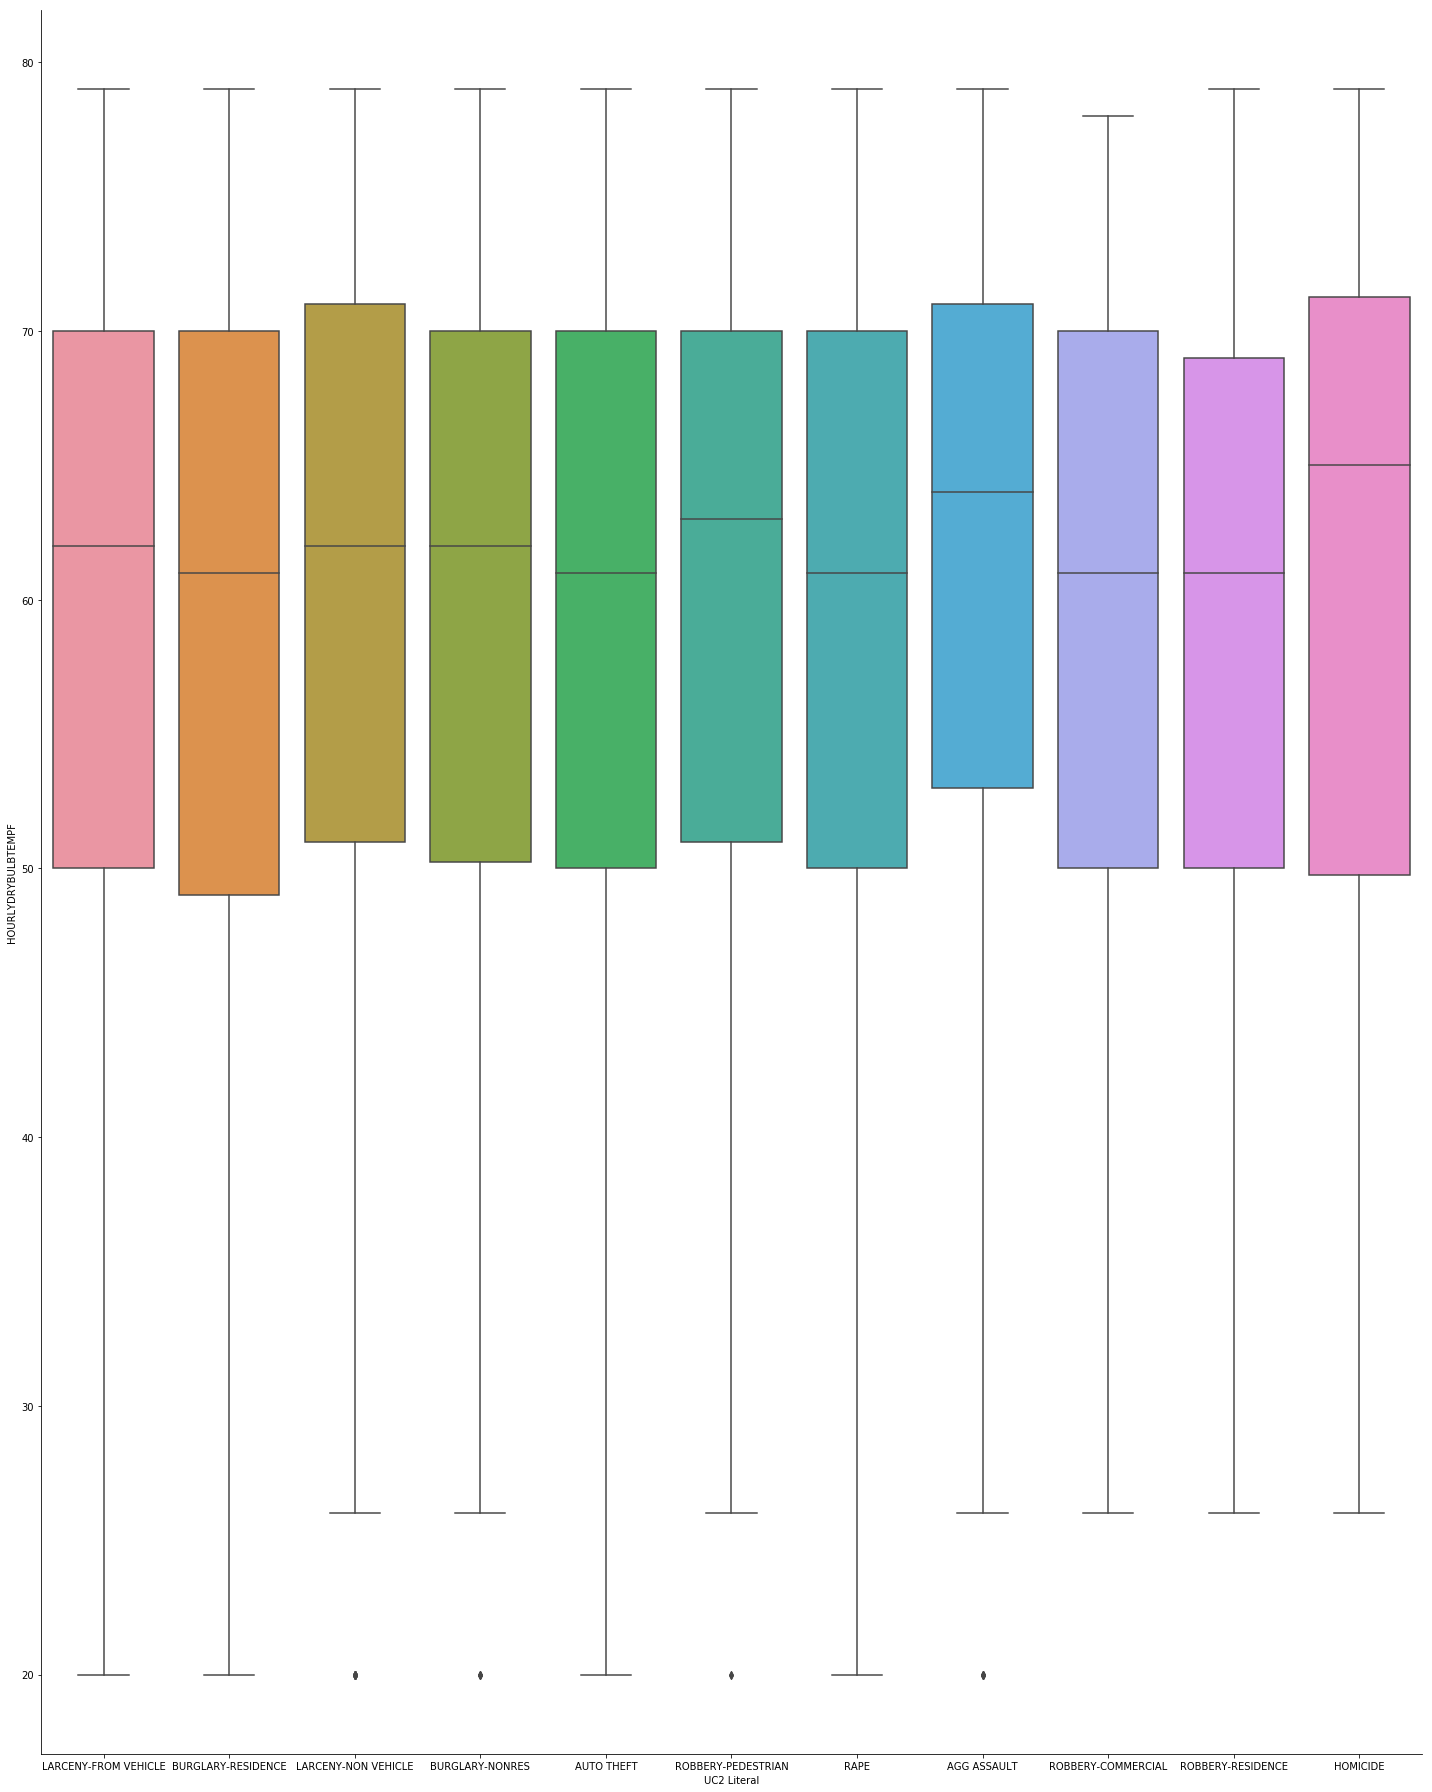

In [143]:
sns.catplot(x="UC2 Literal", y="HOURLYDRYBULBTEMPF", kind = 'box', data=CrimeWeatherData, height = 25, aspect = .8);

In [144]:
#Shuffle the Data to Do Predictive Analysis
CrimeWeatherData = CrimeWeatherData.sample(frac=1)
print CrimeWeatherData

           Date  occur_time poss_date poss_time  MaxOfnum_victims Avg Day  \
24502   5/30/17    220000.0   5/30/17  23:00:00               2.0     Tue   
4833     7/3/17     71000.0    7/3/17   7:10:00               1.0     Mon   
14167   10/2/17    153000.0   10/2/17  15:40:00               1.0     Mon   
10453   1/26/17    123000.0   1/26/17  13:03:00               1.0     Thu   
16674    3/4/17    170000.0    3/4/17  23:09:00               1.0     Sat   
9854     3/6/17    120000.0    3/6/17   0:00:00               1.0     Sun   
15148   3/22/17    160000.0   3/22/17   9:12:00               1.0     Wed   
14712   12/8/17    160000.0   12/8/17  21:00:00               1.0     Fri   
4802    1/12/17     70000.0   1/12/17   7:37:00               1.0     Thu   
25252   1/11/17    223000.0   1/11/17  14:00:00               1.0     Wed   
7180   10/25/17    100000.0  10/25/17  10:05:00               1.0     Wed   
60     11/16/17         0.0  11/16/17   0:00:00               1.0     Unk   

In [146]:

CrimeWeatherData['Avg Day'] = CrimeWeatherData['Avg Day'].astype('category')
CrimeWeatherData['Avg Day'] = CrimeWeatherData['Avg Day'].cat.codes
CrimeWeatherData['UC2 Literal'] = CrimeWeatherData['UC2 Literal'].astype('category')
CrimeWeatherData['UC2 Literal'] = CrimeWeatherData['UC2 Literal'].cat.codes
print CrimeWeatherData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26748 entries, 24502 to 22869
Data columns (total 17 columns):
Date                      26748 non-null object
occur_time                26748 non-null float64
poss_date                 26748 non-null object
poss_time                 26745 non-null object
MaxOfnum_victims          26684 non-null float64
Avg Day                   26748 non-null int8
UC2 Literal               26748 non-null int8
neighborhood              25563 non-null object
x                         26748 non-null float64
y                         26748 non-null float64
HOURLYVISIBILITY          26748 non-null float64
HOURLYDRYBULBTEMPF        26748 non-null float64
HOURLYRelativeHumidity    26748 non-null float64
HOURLYWindSpeed           26748 non-null float64
HOURLYStationPressure     26748 non-null float64
DAILYSunrise              26748 non-null float64
DAILYSunset               26748 non-null float64
dtypes: float64(11), int8(2), object(4)
memory usage: 3.3+ MB
No

## Can we predict crime type based on temperature?

In [156]:
#Model: KNN
#separate into training and testing models. 80% used for training each model, 20% for testing
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['HOURLYDRYBULBTEMPF'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))  

[[  65   38    0   10    0  166   90    0    0    0    0]
 [  78   61    0   32    0  305  130    0    0    0    0]
 [  22   19    0    4    0   73   30    0    0    0    0]
 [  66   40    0   22    0  300  116    0    0    0    0]
 [   4    0    0    0    0   11    3    0    0    0    0]
 [ 260  185    0   68    0 1033  466    0    0    0    0]
 [ 160  123    0   54    0  685  299    0    0    0    0]
 [   6    3    0    1    0   31    5    0    0    0    0]
 [   7    2    0    1    0   14    4    0    0    0    0]
 [  27   21    0    8    0  118   55    0    0    0    0]
 [   3    3    0    1    0   18    4    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.09      0.18      0.12       369
          1       0.12      0.10      0.11       606
          2       0.00      0.00      0.00       148
          3       0.11      0.04      0.06       544
          4       0.00      0.00      0.00        18
          5       0.38      0.51      0.43

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [162]:
#Model: RandomForest
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['HOURLYDRYBULBTEMPF'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

RFC = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RFC.fit(X_train,y_train)
y_pred2 = RFC.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred2))  
print(classification_report(y_test, y_pred2))  

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy Score: 
0.3613084112149533
[[   0    0    0    0    0  412    0    0    0    0    0]
 [   0    0    0    0    0  649    0    0    0    0    0]
 [   0    0    0    0    0  183    0    0    0    0    0]
 [   0    0    0    0    0  541    0    0    0    0    0]
 [   0    0    0    0    0    9    0    0    0    0    0]
 [   0    0    0    0    0 1933    0    0    0    0    0]
 [   0    0    0    0    0 1315    0    0    0    0    0]
 [   0    0    0    0    0   38    0    0    0    0    0]
 [   0    0    0    0    0   28    0    0    0    0    0]
 [   0    0    0    0    0  219    0    0    0    0    0]
 [   0    0    0    0    0   23    0    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       412
          1       0.00      0.00      0.00       649
          2       0.00      0.00      0.00       183
          3       0.00      0.00      0.00       541
          4       0.00      0.00      0.00         9
      

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [167]:
#Model: DecisionTree
X_train, X_test, y_train, y_test = train_test_split(CrimeWeatherData['HOURLYDRYBULBTEMPF'], CrimeWeatherData['UC2 Literal'], test_size=0.20)
X_train = X_train.values
X_train = X_train.reshape(-1, 1)
y_train = y_train.values
y_train = y_train.reshape(-1, 1)

X_test = X_test.values
X_test = X_test.reshape(-1, 1)
y_test = y_test.values
y_test = y_test.reshape(-1, 1)

DT = tree.DecisionTreeClassifier()
DT.fit(X_train,y_train)
y_pred3 = DT.predict(X_test)
print "Accuracy Score: "
print RFC.score(X_test,y_test)
print(confusion_matrix(y_test, y_pred3))  
print(classification_report(y_test, y_pred3))  
import graphviz 
dot_data = tree.export_graphviz(DT, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("./DecisionTrees/TempVsCrime") 

Accuracy Score: 
0.36672897196261683
[[   0    0    0    0    0  386    1    0    0    0    0]
 [   0    0    0    0    0  607    1    0    0    0    0]
 [   0    0    0    0    0  167    0    0    0    0    0]
 [   0    0    0    0    0  520    1    0    0    0    0]
 [   0    0    0    0    0   13    1    0    0    0    0]
 [   0    0    0    0    0 1959    3    0    0    0    0]
 [   0    0    0    0    0 1348    3    0    0    0    0]
 [   0    0    0    0    0   55    0    0    0    0    0]
 [   0    0    0    0    0   23    0    0    0    0    0]
 [   0    0    0    0    0  238    0    0    0    0    0]
 [   0    0    0    0    0   24    0    0    0    0    0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       387
          1       0.00      0.00      0.00       608
          2       0.00      0.00      0.00       167
          3       0.00      0.00      0.00       521
          4       0.00      0.00      0.00        14
     

/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'./DecisionTrees/TempVsCrime.pdf'